## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [1126]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [1127]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_select' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (60, 6)


serum table has 36 samples and 1071 metabolites

In [1128]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)


In [1129]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != 'DEG']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != 'DEG']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS != 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 47) 
 (24, 60)


In [1130]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [1131]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 0 rows in serum file and 0 in muscle


In [1132]:
# df_na = df_na.drop(index='UCAM-55724',axis=0)

# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
muscle_na = pd.merge(left = muscle_na, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_na = muscle_na.set_index('MouseID')
muscle_na.head()

In [1133]:
grouped = muscle_na.groupby('Group') # organize data by groups
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.copy().fillna(df.median(axis=0))
    if scale_by == 1:
        df = df.div(df.median())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
    return df



In [1134]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,0,1)
serum_med = met_transform(serum_na,1,0,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [1135]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method
    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    return df_fwn


In [1136]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.3829787234042553 
 The proportion of normally distributed columns with method_2 is: 0.7446808510638298
take 10 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.6833333333333333 
 The proportion of normally distributed columns with method_2 is: 0.6666666666666666
take 28 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [1137]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [1138]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_fwn['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_fwn['Tx'] = muscle_fwn.Group.str[0]
muscle_fwn['Ex'] = muscle_fwn.Group.str[1]
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,dihydroxyacetonephosphateDHAP,lactate,glucose,citrate,ethylmalonate,butyrylcarnitineC,alphahydroxyisovalerate,aconitatecisortrans,hydroxymethylvalerate,methylglutaconate,...,hydroxybutyratehydroxyisobutyrate,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-0.444318,-0.501151,-1.106517,-1.622911,0.851704,-0.288775,-0.122533,-1.105443,-0.173585,1.442313,...,-0.617765,1.381771,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-0.810680,0.392569,0.406768,-0.055839,0.455245,0.588979,0.297943,-0.380996,-1.198554,0.150511,...,-0.687829,-0.167103,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
HR40,0.232520,-0.344193,-1.160984,0.698598,0.379661,1.059056,-1.625800,1.333990,-1.756625,-0.429309,...,-0.390560,1.226444,HR,H,R,1.622066,2.154468,1.571252,0.186733,-0.585547
HS41,-0.916237,-0.032302,-0.043937,-0.410730,1.705517,0.745285,1.774351,-0.222297,0.647608,0.172051,...,-1.136796,-0.088586,HS,H,S,-0.550738,-0.720618,-0.845068,-0.713733,-0.537709
VR60,0.367445,-0.136651,-0.242806,0.257153,-0.537497,-0.489853,0.778038,0.745259,1.455183,0.788485,...,0.473637,-0.812753,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418


In [1139]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
samples_2HB = serum_samples[serum_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
serum_fwn['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_fwn['Tx'] = serum_fwn.Group.str[0]
serum_fwn['Ex'] = serum_fwn.Group.str[1]
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,alphaketoglutarate,hydroxymethylglutarate,hypoxanthine,succinate,isoleucine,leucine,lactate,valine,glucose,malonate,...,succinylcarnitineCDC,dihydroxymethylbutyrate,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,1.364703,-0.398099,-0.502351,0.168097,-0.570326,-0.402917,0.658815,-0.359660,0.219167,0.961990,...,-0.339377,0.149920,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-1.436328,-1.761484,-0.548995,-2.079906,-2.537805,-2.382523,-0.612141,-2.261316,-0.898904,0.094304,...,1.215029,-1.190974,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
HR40,0.997063,1.074123,0.859143,0.192452,0.013403,0.027284,1.121213,0.220229,0.236218,1.101497,...,0.510039,-1.525900,HR,H,R,1.622066,2.154468,1.571252,0.186733,-0.585547
HS41,-0.081214,-0.419249,1.118035,0.386621,-0.752458,-0.367220,1.579432,-0.449122,-0.098332,-1.011318,...,2.247996,0.490358,HS,H,S,-0.550738,-0.720618,-0.845068,-0.713733,-0.537709
VR42,1.480669,-0.039460,0.242520,-0.704093,0.503777,0.117657,-0.785487,0.339290,-1.117495,-0.694942,...,1.072608,0.167658,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123


In [1140]:
# conduct basic differential abundance analysis
import scipy.stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from pingouin import ancova

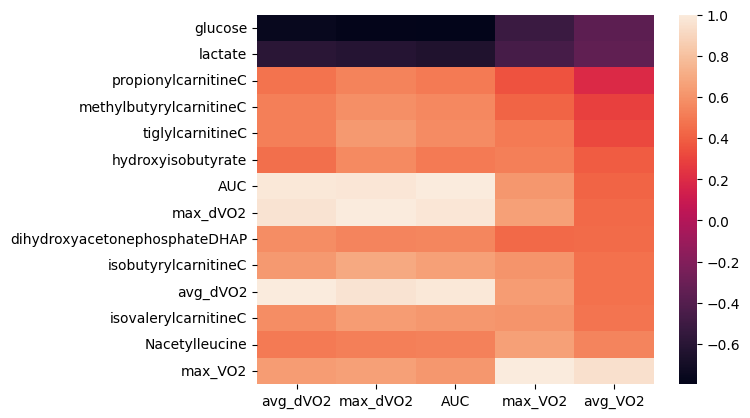

In [1141]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

In [1142]:
corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5]

,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
glucosephosphate,-0.504383,-0.510727,-0.480093,-0.547287,-0.475815
alphaketoglutarate,0.614122,0.617769,0.627692,0.213186,0.019658
hydroxybutyrateBHBA,0.417057,0.502732,0.457185,0.284927,0.163356
hydroxyglutarate,0.486746,0.514879,0.444320,0.390597,0.266810
hydroxybutyratehydroxyisobutyrate,0.533703,0.559255,0.493826,0.412476,0.292493
isocitrate,0.538704,0.514570,0.446927,0.381066,0.302968
aconitatecisortrans,0.797349,0.820076,0.807747,0.501039,0.303314
methylcrotonylglycine,0.772742,0.813759,0.752658,0.584888,0.401778
AUC,0.979937,0.964851,1.000000,0.609819,0.403782
butyrylglycineC,0.541642,0.527146,0.455196,0.531258,0.414483


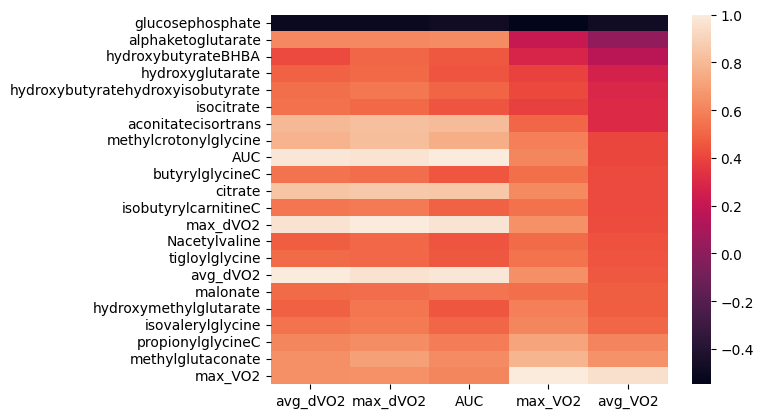

In [1143]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

In [1148]:
results = pd.DataFrame(columns=['Metabolite','p_value','AIC'])
ancova_fwn = pd.merge(left=muscle_fwn,
                      right=serum_fwn[['hydroxybutyratehydroxyisobutyrate','glucose','carnitine','hypoxanthine']].add_suffix('_ser'),how='left',left_index=True,right_index=True,)
# ancova_fwn = ancova_fwn[ancova_fwn.Ex == 'R']
covars=['hydroxybutyratehydroxyisobutyrate_ser','glucose_ser','carnitine_ser','hypoxanthine_ser','avg_VO2','max_dVO2']
for met in ancova_fwn.columns[:-13]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Group')
    model = sm.OLS(ancova_fwn[met],ancova_fwn[covars]).fit()
    aic = model.aic
    results.loc[len(results)] = pd.Series({
        'Metabolite':met,
        'p_value':ancova_table.iloc[0,4],
        'AIC':aic

    })

In [1145]:
results = pd.DataFrame(columns=['Metabolite','p_value','AIC'])
ancova_fwn = pd.merge(left=serum_fwn,
                      right=muscle_fwn[['hydroxybutyratehydroxyisobutyrate','glucose']].add_suffix('_mus'),how='left',left_index=True,right_index=True,)
# ancova_fwn = ancova_fwn[ancova_fwn.Ex == 'R']
covars=['hydroxybutyratehydroxyisobutyrate_mus','glucose_mus','avg_VO2','max_dVO2']
for met in ancova_fwn.columns[:-10]:
    # print(met) # for tracking progress in loop
    ancova_table = ancova(data=ancova_fwn, dv=f'{met}', covar=covars, between='Group')
    model = sm.OLS(ancova_fwn[met],ancova_fwn[covars]).fit()
    aic = model.aic
    results.loc[len(results)] = pd.Series({
        'Metabolite':met,
        'p_value':ancova_table.iloc[0,4],
        'AIC':aic

    })

In [1151]:
results[results.p_value < 0.3].sort_values(by='p_value').reset_index()

,index,Metabolite,p_value,AIC,adj_p,reject
0,24,Nacetylleucine,0.004426,61.618723,0.203574,False
1,37,isovalerylglycine,0.029107,63.171502,0.615327,False
2,9,methylglutaconate,0.04013,72.863073,0.615327,False
3,41,tiglylcarnitineC,0.09134,59.3718,0.680046,False
4,21,valine,0.105624,72.438142,0.680046,False
5,22,malonate,0.129219,67.894406,0.680046,False
6,34,propionylcarnitineC,0.172016,67.852432,0.680046,False
7,10,alphaketoglutarate,0.176743,76.217393,0.680046,False
8,45,hydroxybutyratehydroxyisobutyrate,0.179011,50.646886,0.680046,False
9,42,deoxycarnitine,0.182402,74.734323,0.680046,False


In [1150]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
results[results.reject == True]

reject
False    46
Name: count, dtype: int64


,Metabolite,p_value,AIC,adj_p,reject


### OLD section

In [931]:
grouped = muscle_fwn.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite', 'VS_mean', 'VR_mean', 'HS_mean', 'HR_mean','VS_var','VR_var','HS_var','HR_var', 'p_value']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_fwn.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform anova
    test_stat, p_value = ttest_ind(VR, HR)
    # get group means
    VS_mean = VS.mean()
    VR_mean = VR.mean()
    HS_mean = HS.mean()
    HR_mean = HR.mean()
    VS_var = VS.var()
    VR_var = VR.var()
    HS_var = HS.var()
    HR_var = HR.var()
    VR_HR = VR_mean - HR_mean
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'VS_mean': VS_mean,
                              'VR_mean': VR_mean,
                              'HS_mean': HS_mean,
                              'HR_mean': HR_mean,
                              'VS_var': VS_var,
                              'VR_var': VR_var,
                              'HS_var': HS_var,
                              'HR_var': HR_var,
                              'p_value': p_value})



In [2813]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject


(array([6., 6., 4., 4., 8., 4., 4., 1., 4., 5.]),
 array([0.07273492, 0.16539239, 0.25804987, 0.35070735, 0.44336483,
        0.5360223 , 0.62867978, 0.72133726, 0.81399474, 0.90665221,
        0.99930969]),
 <BarContainer object of 10 artists>)

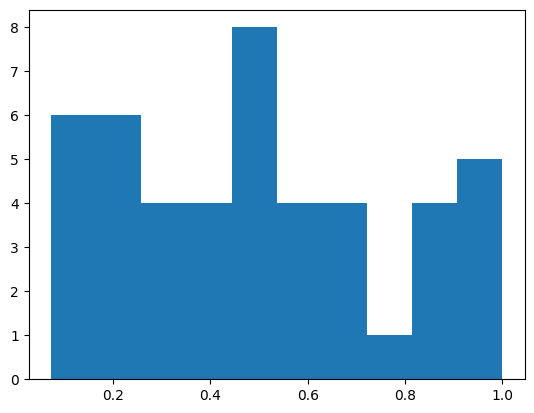

In [2814]:
plt.hist(results.p_value)

In [2815]:
results.reject.value_counts()

reject
False    46
Name: count, dtype: int64

### Attempting Two-Way ANOVA
Really just want an indication that there is an interaction between 2HB and exercise in modifying some of the metabolites

In [2820]:
results = pd.DataFrame(columns=['Metabolite', 'ME_Tx', 'ME_Ex', 'Interaction']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in df_fwn_scale.columns[:-3]:
    #create model and perform anova
    model = ols(f'{met} ~ C(Tx) + C(Ex) + C(Tx):C(Ex)', data=df_fwn_scale).fit()
    result = sm.stats.anova_lm(model, type=2)

    # main effect and interaction
    ME_Tx = result.iloc[0,4]
    ME_Ex = result.iloc[1,4]
    Interaction = result.iloc[1,4]
    # append data to the results table
    results.loc[len(results)] = pd.Series({'Metabolite': met,
                              'ME_Tx': ME_Tx,
                              'ME_Ex': ME_Ex,
                              'Interaction': Interaction})



reject
False    33
True     13
Name: count, dtype: int64


(array([13.,  6.,  3.,  4.,  0.,  2.,  0.,  6.,  4.,  8.]),
 array([0.00152436, 0.09999203, 0.19845971, 0.29692738, 0.39539505,
        0.49386273, 0.5923304 , 0.69079808, 0.78926575, 0.88773343,
        0.9862011 ]),
 <BarContainer object of 10 artists>)

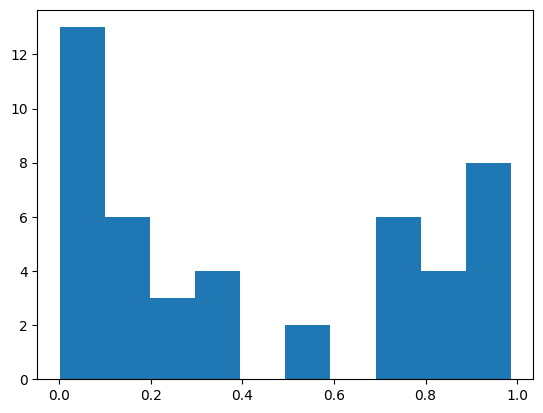

In [2821]:
reject, adj_pvalues, sidak, bonf = multipletests(
    results.Interaction.fillna(1), alpha=0.1, method = 'fdr_bh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
print(results.reject.value_counts())
plt.hist(results.adj_p)